In [1]:
import pandas as pd 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer



In [4]:
data = pd.read_csv('./datasets/classification/titanic.csv')

print(data.head(10))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54

In [5]:
print(data.describe())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


In [6]:
# target dataframe: data
target = "Survived"
features = list(data.columns.drop("Survived"))
feature_df = data[features]

prediction_df = data

# get numerical and categorical columns
bool_cols = feature_df.select_dtypes(include=['bool']).columns.tolist()
data[bool_cols] = feature_df[bool_cols].astype(int)
numerical_cols = feature_df.select_dtypes(include=['int', 'float']).columns.tolist()
categorical_cols = feature_df.select_dtypes(include=['object']).columns.tolist()
text_cols = feature_df.select_dtypes(include=['string']).columns.tolist()


sample_size = np.min([10000, data.shape[0]])
unique_theshold = np.min([100, sample_size/10])

# check categorical columns for high cardinality and make it text column
for col in categorical_cols:
    if data[col].sample(sample_size).nunique() > unique_theshold:
        text_cols.append(col)
        categorical_cols.remove(col)
        

# check text columns for low cardinality and make it categorical columns
for col in text_cols:
    if data[col].sample(sample_size).nunique() < unique_theshold:
        categorical_cols.append(col)
        text_cols.remove(col)

print(numerical_cols)
print(categorical_cols)
print(text_cols)

# define numeric transformer steps
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")), 
        ("scaler", MinMaxScaler())]
)

# define categorical transformer steps
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")), 
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

# define text transformer steps
text_transformer = Pipeline(
    steps=[
        ('text', TfidfVectorizer())
    ]
)

# create the preprocessing pipelines for both numeric and categorical data
preprocessor = ColumnTransformer(
        transformers=[('num', numeric_transformer , numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
        *[(f'text_{t_col}', text_transformer, t_col) for t_col in text_cols]]
)

['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
['Sex', 'Cabin', 'Embarked']
['Name', 'Ticket']


In [8]:
# train test split
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_comparison_list = []

In [9]:

##### Model Pipeline for Decision Tree Classifier #####

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,make_scorer,f1_score,precision_score,recall_score,roc_auc_score,roc_curve,auc
import matplotlib.pyplot as plt
dt_classifier_param_grid = {
"dt_classifier__max_depth": np.arange(2, 10, 2),
"dt_classifier__min_samples_split": np.arange(2, 10, 2),
"dt_classifier__min_samples_leaf": np.arange(1, 10, 5),
"dt_classifier__min_weight_fraction_leaf": np.arange(0.0, 0.5, 0.25),
"dt_classifier__max_leaf_nodes": np.arange(1, 10, 5),
"dt_classifier__min_impurity_decrease": np.arange(0.0, 0.5, 0.25),
}


# Create the pipeline
dt_classifier_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('dt_classifier', DecisionTreeClassifier())
])

# Create the grid search
dt_classifier_grid_search = GridSearchCV(estimator=dt_classifier_pipe, param_grid=dt_classifier_param_grid, cv=5, scoring=make_scorer(accuracy_score), verbose=3)
dt_classifier_grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV 1/5] END dt_classifier__max_depth=2, dt_classifier__max_leaf_nodes=1, dt_classifier__min_impurity_decrease=0.0, dt_classifier__min_samples_leaf=1, dt_classifier__min_samples_split=2, dt_classifier__min_weight_fraction_leaf=0.0;, score=nan total time=   0.0s
[CV 2/5] END dt_classifier__max_depth=2, dt_classifier__max_leaf_nodes=1, dt_classifier__min_impurity_decrease=0.0, dt_classifier__min_samples_leaf=1, dt_classifier__min_samples_split=2, dt_classifier__min_weight_fraction_leaf=0.0;, score=nan total time=   0.0s
[CV 3/5] END dt_classifier__max_depth=2, dt_classifier__max_leaf_nodes=1, dt_classifier__min_impurity_decrease=0.0, dt_classifier__min_samples_leaf=1, dt_classifier__min_samples_split=2, dt_classifier__min_weight_fraction_leaf=0.0;, score=nan total time=   0.0s
[CV 4/5] END dt_classifier__max_depth=2, dt_classifier__max_leaf_nodes=1, dt_classifier__min_impurity_decrease=0.0, dt_classifier__min_samples_leaf=1,

c:\Users\umerk\anaconda3\envs\can_temp\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
640 fits failed out of a total of 1280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
640 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\umerk\anaconda3\envs\can_temp\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\umerk\anaconda3\envs\can_temp\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\umerk\anaconda3\envs\can_temp\lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['PassengerId',
                                                                          'Pclass',
                                                                          'Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_...
             param_grid={'dt_classifier__max_depth': array([2, 4, 6, 8]),
                         'dt_classifier__max_leaf_nodes': array([1, 6]),
                         'dt_classifier__min_impurity_decrease': array([0.  , 0.25]),
                         'dt_classifier__min_samples_leaf': array([1, 6]),
                         'dt_classifier__min_samples_split': array([2, 4, 6, 8]),
                         'dt_classifier__min_weight_fraction_leaf': array([0.  , 0.25])},
             scoring=make_scorer(accuracy_score), verbose=3)

In [10]:
# Get the best hyperparameters
dt_classifier_best_estimator = dt_classifier_grid_search.best_estimator_

# Store results as a dataframe  
dt_classifier_search_results = pd.DataFrame(dt_classifier_grid_search.cv_results_)

print(dt_classifier_search_results)

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.027997      0.002251         0.000000        0.000000   
1         0.029519      0.002266         0.000000        0.000000   
2         0.029344      0.003392         0.000000        0.000000   
3         0.032367      0.001461         0.000000        0.000000   
4         0.033921      0.002797         0.000000        0.000000   
..             ...           ...              ...             ...   
251       0.023682      0.001348         0.008200        0.000721   
252       0.025213      0.002362         0.008539        0.000553   
253       0.025461      0.003935         0.009652        0.000646   
254       0.024773      0.002846         0.010592        0.001848   
255       0.032981      0.005461         0.012030        0.001187   

    param_dt_classifier__max_depth param_dt_classifier__max_leaf_nodes  \
0                                2                                   1   
1                      

           model         metric     value
4  dt_classifier  roc_auc_score  0.842471


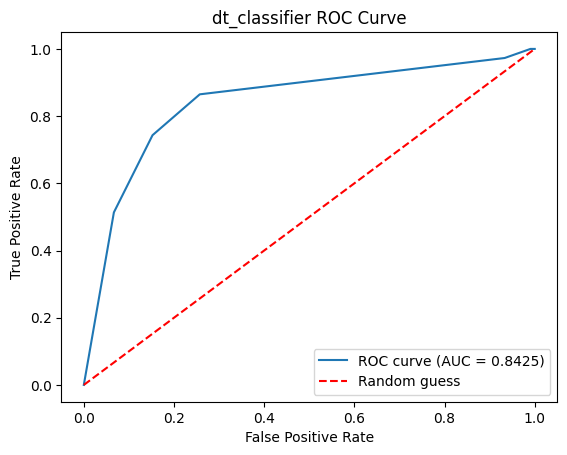

In [11]:
# Model metrics

# Generate Predictions
dt_classifier_predictions = pd.DataFrame(dt_classifier_best_estimator.predict(X_test))

dt_classifier_predictions_prob = dt_classifier_best_estimator.predict_proba(X_test)
dt_classifier_predictions_prob_df = pd.DataFrame()
dt_classifier_predictions_prob_df[dt_classifier_grid_search.classes_[0]] = dt_classifier_predictions_prob[:,0]
dt_classifier_predictions_prob_df[dt_classifier_grid_search.classes_[1]] = dt_classifier_predictions_prob[:,1] 


# Generate Model Metrics
dt_classifier_accuracy = accuracy_score(y_test, dt_classifier_predictions.iloc[:,0])
dt_classifier_f1_score = f1_score(y_test, dt_classifier_predictions.iloc[:,0])
dt_classifier_precision = precision_score(y_test, dt_classifier_predictions.iloc[:,0])
dt_classifier_recall = recall_score(y_test, dt_classifier_predictions.iloc[:,0])
dt_classifier_roc_auc_score = roc_auc_score(y_test, dt_classifier_predictions_prob_df[dt_classifier_grid_search.classes_[1]])
dt_classifier_performance_metrics = [['dt_classifier','accuracy',dt_classifier_accuracy], 
                                  ['dt_classifier','f1_score',dt_classifier_f1_score],
                                  ['dt_classifier','precision', dt_classifier_precision],
                                  ['dt_classifier','recall', dt_classifier_recall],
                                  ['dt_classifier','roc_auc_score', dt_classifier_roc_auc_score]]
dt_classifier_performance_metrics = pd.DataFrame(dt_classifier_performance_metrics, columns=['model','metric', 'value'])
fpr, tpr, thresholds = roc_curve(y_test, dt_classifier_predictions_prob_df[dt_classifier_grid_search.classes_[1]])
roc_auc = auc(fpr, tpr)

# ROC Curve plot
dt_classifier_roc_auc_plot, dt_classifier_roc_auc_plot_ax = plt.subplots()
dt_classifier_roc_auc_plot_ax.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
dt_classifier_roc_auc_plot_ax.plot([0, 1], [0, 1], 'r--', label='Random guess')
# Set axis labels and title
dt_classifier_roc_auc_plot_ax.set_xlabel('False Positive Rate')
dt_classifier_roc_auc_plot_ax.set_ylabel('True Positive Rate')
dt_classifier_roc_auc_plot_ax.set_title(f'dt_classifier ROC Curve')
# Add legend
dt_classifier_roc_auc_plot_ax.legend()


print(dt_classifier_performance_metrics[dt_classifier_performance_metrics['metric'] == 'roc_auc_score'])


           model         metric     value
4  dt_classifier  roc_auc_score  0.842471
The best model is dt_classifier with 0.8424710424710425 as roc_auc_score
Predictions from best model are stored in test_predictions


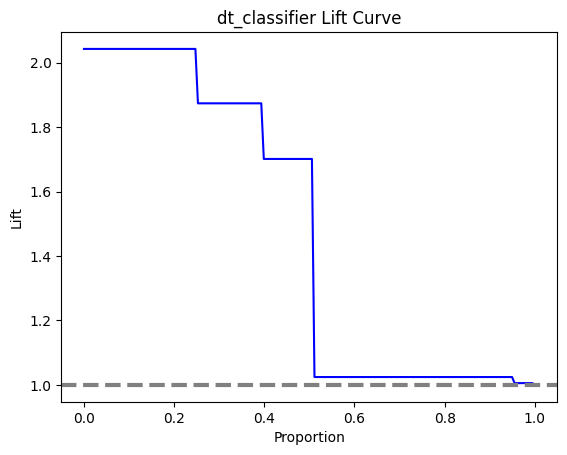

In [12]:
# Lift Chart
aux_df = pd.DataFrame()
aux_df['y_real'] = y_test
aux_df['y_proba'] = dt_classifier_predictions_prob_df.iloc[:,1].values

# Sort by predicted probability
aux_df = aux_df.sort_values('y_proba', ascending=False)

# Find the total positive ratio of the whole dataset
total_positive_ratio = sum(aux_df['y_real'] == 1) / aux_df.shape[0]

# For each line of data, get the ratio of positives of the given subset and calculate the lift
lift_values = []
for i in aux_df.index:
    threshold = aux_df.loc[i]['y_proba']
    subset = aux_df[aux_df['y_proba'] >= threshold]
    subset_positive_ratio = sum(subset['y_real'] == 1) / subset.shape[0]
    lift = subset_positive_ratio / total_positive_ratio
    lift_values.append(lift)

# Plot the lift curve
dt_classifier_lift_plot, dt_classifier_lift_plot_ax = plt.subplots()
dt_classifier_lift_plot_ax.set_xlabel('Proportion')
dt_classifier_lift_plot_ax.set_ylabel('Lift')
dt_classifier_lift_plot_ax.set_title(f'dt_classifier Lift Curve')

# plot the lift curve
x_vals = np.linspace(0, 1, num=len(lift_values))
dt_classifier_lift_plot_ax.plot(x_vals, lift_values, color='b')

# add dashed horizontal line at lift of 1
dt_classifier_lift_plot_ax.axhline(y=1, color='gray', linestyle='--', linewidth=3)


model_comparison_list.append(dt_classifier_performance_metrics)##### End of Model Pipeline for Decision Tree Classifier #####
##### Model Comparison #####

table = pd.concat(model_comparison_list)
table = table.sort_values(by=['value'], ascending=False)
table = table[table['metric'] == 'roc_auc_score']
print(table)
print(f"The best model is {table['model'].iloc[0]} with {table['value'].iloc[0]} as {table['metric'].iloc[0]}")


# Predict test data using the best model
test_predictions = eval(table['model'].iloc[0]+"_best_estimator").predict(prediction_df)
print('Predictions from best model are stored in test_predictions')
